# STA 220 Assignment 4

Due __March 8, 2024__ by __11:59pm__. Submit your work by uploading it to Gradescope through Canvas.

Instructions:

1. Provide your solutions in new cells following each exercise description. Create as many new cells as necessary. Use code cells for your Python scripts and Markdown cells for explanatory text or answers to non-coding questions. Answer all textual questions in complete sentences.
2. The use of assistive tools is permitted, but must be indicated. You will be graded on you proficiency in coding. Produce high quality code by adhering to proper programming principles. 
3. Export the .jpynb as .pdf and submit it on Gradescope in time. To facilitate grading, indicate the area of the solution on the submission. Submissions without indication will be marked down. No late submissions accepted. 
4. If test cases are given, your solution must be in the same format. 
5. The total number of points is 10. 

__Exercise 1__ Lets retrieve data from the [CIA World Factbook](https://www.cia.gov/the-world-factbook/) and visualize parts of it. 

__(a)__ Using devtools, find a way to retrieve the names of all listed world entities. In order to navigate to their respective site, I assembled the path by processing the country names. To this end, __(i)__ write a function `process_names` that processes the name as string according to the requests query parameter. _Run:_ 
```
process_names('Falkland Islands (Islas Malvinas)')
```

In [1]:
import re

def process_names(input_string):
    # Convert the string to lowercase
    processed_string = input_string.lower()
    
    # Use regular expression to remove parentheses and replace spaces with '-'
    processed_string = re.sub(r'[\(\)]', '', processed_string)
    processed_string = re.sub(r'\s', '-', processed_string)
    
    return processed_string

In [2]:
print(process_names('French Southern and Antarctic Lands'))
print(process_names('Bahamas, The'))
print(process_names('Falkland Islands (Islas Malvinas)'))


french-southern-and-antarctic-lands
bahamas,-the
falkland-islands-islas-malvinas


__(ii)__ Obtain all world entity names. _How many have you found? Hint: I could not retrieve data for all 266 entities that the CIA WFB claims to have._

In [3]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import re
import json
import requests
from bs4 import BeautifulSoup
import time

In [5]:
# Set up the Selenium WebDriver with Firefox
driver = webdriver.Firefox()  # Ensure geckodriver is installed and in your PATH

# Open the website
driver.get("https://www.cia.gov/the-world-factbook/countries/")
name_list = []
for _ in range(23):
    next_arrow = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CSS_SELECTOR,'svg.icon-arrow-wide[aria-label="Forwards"]')))
    next_arrow.click()
    elements = driver.find_elements(By.XPATH, '//a/.[@class="inline-link"]')

    for element in elements:
        if element not in name_list:
            name_list.append(process_names(element.text))




In [6]:
name_list = set(name_list)
name_list = list(name_list)
print(f"There are {len(name_list)} countries extracted")

There are 262 countries extracted


__(iii)__ Write a function `get_info` takes a country name as string as input and return all the information as json that is displayed on its respective site. Use the retrieved data set for the next exercises. _Hint: If you rate-limit your requests (you should!) this may take up to 10 minutes._

In [7]:
def get_info(country_name):
    base = "https://www.cia.gov/the-world-factbook/countries/"
    url = base + country_name
    bs = BeautifulSoup(requests.get(url).text)
    texts = bs.find_all('h3', {'class':"mt30"})
    info = {}
    for text in texts:
        title = text.text
        stuff = text.find_next_siblings()
       
        paragraphs = [tag.get_text(strip=True) for tag in stuff]
        single_paragraph = ' '.join(paragraphs)
        info[title] = single_paragraph

    # Join the paragraphs into a single paragraph
    return info

us = get_info("united-states")

'major seaport(s):Atlantic Ocean:Charleston, Hampton Roads, New York/New Jersey, SavannahPacific Ocean:Long Beach, Los Angeles, Oakland, Seattle/TacomaGulf of Mexico:Houstonoil terminal(s):LOOP terminal, Haymark terminalcontainer port(s) (TEUs):Charleston (2,751,442), Hampton Roads (3,522,834), Houston (3,453,220), Long Beach (9,384,368), Los Angeles (10,677,610), New York/New Jersey (8,985,929), Oakland (2,448,243), Savannah (5,613,163), Seattle/Tacoma (3,736,206) (2021)LNG terminal(s) (export):Calcasieu Pass (LA), Cameron (LA), Corpus Christi (TX), Cove Point (MD), Elba Island (GA), Freeport (TX), Sabine Pass (LA)note - two additional export facilities are under construction and expected to begin commercial operations in 2023-2024LNG terminal(s) (import):Cove Point (MD), Elba Island (GA), Everett (MA), Freeport (TX), Golden Pass (TX), Hackberry (LA), Lake Charles (LA), Neptune (offshore), Northeast Gateway (offshore), Pascagoula (MS), Sabine Pass (TX)river port(s):Baton Rouge, Plaque

In [95]:
#country_info = {}
#for country in name_list:
#    country_info[country] = get_info(country)
#    time.sleep(3)

In [109]:
#import pickle

#with open("../Data/countries.pkl", "ab") as f:
#    pickle.dump(country_info, f)

In [8]:
import pickle
country_info = {}
with open("../Data/countries.pkl", "rb") as f:
    while True:
        try:
            a = pickle.load(f)
        except EOFError:
            break
        else:
            country_info.update(a)

__(b)__ Lets learn about the newest updated data points in the CIA world factbook - the merchant marine! __(i)__ Write a function `ports` that returns a list of all major seaports of a given country. _Run:_

```
ports('United States')
```

In [9]:
def ports(country, info = country_info):
    if('Ports and terminals' in info[country]):
        given_string = info[country].get('Ports and terminals')
        major_seaports_match = re.search(r"major seaport\(s\):(.*?)(?=[(])", given_string)
        if major_seaports_match:
            # Check if the pattern is found
            # Get the extracted major seaports
            major_seaports_text = major_seaports_match.group(1).strip()
            # Split the text into a list of major seaports
            major_seaports = [port.strip() for port in major_seaports_text.split(",")]
            return major_seaports
        else:
            return None
    else:
        return None

__(ii)__ Lets put a marker on a world map corresponding to the location of all major seaports that you retrieved. Use the [Nominatim](https://nominatim.org/) API to get latitute-longitude pairs. Make structured queries and pass the `city` and `country` keys. Use the first value that is returned. 

_Print the world map. Name three markers that are apparently misplaced._

In [10]:
ports_dict = {}
for country in name_list:
    ports_dict[country] = ports(country)

In [11]:
ports_dict['united-states']

['Atlantic Ocean:Charleston',
 'Hampton Roads',
 'New York/New Jersey',
 'SavannahPacific Ocean:Long Beach',
 'Los Angeles',
 'Oakland',
 'Seattle/TacomaGulf of Mexico:Houstonoil terminal']

In [12]:
def filter(dictionary):
    filtered = {}
    for key, ports in dictionary.items():
        if dictionary[key]:
            filtered[key] = [item for item in ports if ":" not in item]
    return filtered


In [13]:
filtered_ports = filter(ports_dict)

In [13]:
import lxml
nom_url = "https://nominatim.openstreetmap.org/search"
coord_list = []
for country, cities in filtered_ports.items():
    if cities:
        for city in cities:
            params = {
                'q': f'{country}, {city}',
                'format':'xml',
                'polygon_kml':'1',
                'addressdetails':'1'
            }
            response = requests.get(nom_url, params=params)
            if response.status_code == 200:
                bs = BeautifulSoup(response.text, 'xml')
                if bs.find('place'):
                    lat = bs.find('place')['lat']
                    lon = bs.find('place')['lon']
                    coord = float(lat), float(lon)
                    coord_list.append(coord)


In [14]:
import pickle
with open("../Data/coordinates.pkl", "rb") as f:
    coord_list = pickle.load(f)

C:\Users\alanp\AppData\Local\Temp\ipykernel_33636\1452157452.py:11: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


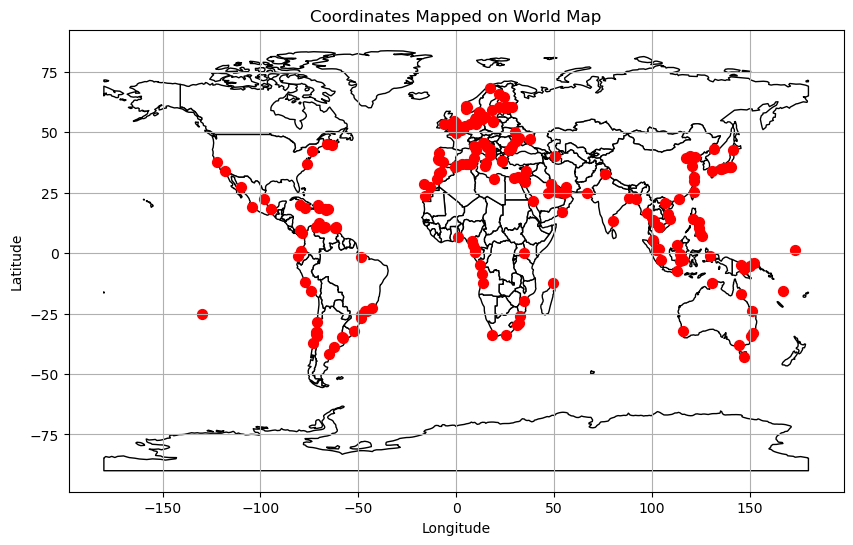

In [16]:
import geopandas as gpd
from shapely.geometry import Point

# List of latitude and longitude coordinates

# Create a GeoDataFrame from the coordinates
geometry = [Point(lon, lat) for lat, lon in coord_list]
gdf = gpd.GeoDataFrame(geometry=geometry, columns=['geometry'])

# Plot the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(10, 6), color='white', edgecolor='black')

# Plot the coordinates on the map
gdf.plot(ax=ax, color='red', markersize=50)

# Show the plot
ax.set_title('Coordinates Mapped on World Map')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.grid(True)
ax.set_aspect('auto')

There are two points out in the sea which is either a port on a small island or incorrect coordinates, in addition, there is on point that may be inside a landlocked area

__(iii)__ Amongst all countries with a major seaport, return the four that have the largest fleet of _bulk carriers_. Amongst all countries with no coastline, return the four that have the largest merchant marine fleet overall. 

In [17]:
seaport_countries = []
for keys, cities in filtered_ports.items():
    if cities:
        seaport_countries.append(keys)
seaport_countries

['philippines',
 'japan',
 'greece',
 'azerbaijan',
 'bangladesh',
 'pakistan',
 'israel',
 'south-africa',
 'taiwan',
 'spain',
 'kazakhstan',
 'bulgaria',
 'hong-kong',
 'madagascar',
 'burma',
 'romania',
 'panama',
 'oman',
 'saudi-arabia',
 'netherlands',
 'cambodia',
 'nigeria',
 'venezuela',
 'india',
 'vietnam',
 'mexico',
 'lebanon',
 'sweden',
 'vanuatu',
 'papua-new-guinea',
 'portugal',
 'germany',
 'poland',
 'sri-lanka',
 'ecuador',
 'kenya',
 'italy',
 'croatia',
 'brunei',
 'peru',
 'el-salvador',
 'belgium',
 'iran',
 'denmark',
 'china',
 'curacao',
 'antigua-and-barbuda',
 'finland',
 'egypt',
 'costa-rica',
 'kiribati',
 'norway',
 'chile',
 'dominican-republic',
 'trinidad-and-tobago',
 'togo',
 'sint-maarten',
 'gabon',
 'kuwait',
 'algeria',
 'canada',
 'lithuania',
 'russia',
 'cayman-islands',
 'libya',
 'colombia',
 'france',
 'qatar',
 'puerto-rico',
 'ukraine',
 'united-states',
 'argentina',
 'pitcairn-islands',
 'british-virgin-islands',
 'turkey-turkiye',

In [18]:
sea_port_bulk = {}
for country in seaport_countries:
    if country_info[country].get('Merchant marine'):
        sea_port_bulk[country] = country_info[country]['Merchant marine']

In [35]:
import pandas as pd
num_bulk = {}
for country, string in sea_port_bulk.items():
    pattern = r'bulk carrier (\d{1,3}(?:,\d{3})*)'

    # Use re.search to find the first occurrence of the pattern in the string
    match = re.search(pattern, string)

    # Extract the number of bulk carriers from the matched group
    if match:
        num_bulk[country] = int(match.group(1).replace(',', ''))  # Remove commas from the number

bulk_df = pd.DataFrame(list(num_bulk.items()), columns = ['Country', 'Bulk Carriers'])
bulk_df.sort_values(by='Bulk Carriers', ascending=False).head(4)

,Country,Bulk Carriers
28,china,1831
9,hong-kong,1047
53,singapore,591
48,malta,490


In [45]:
landlocked_list = []

for key in country_info:
    if country_info[key].get('Coastline'):
        if 'landlocked' in country_info[key]['Coastline']:
            landlocked_list.append(key)

In [60]:
land_marine = {}
for country in landlocked_list:
    if country_info[country].get('Merchant marine'):
        string = country_info[country]['Merchant marine']
        pattern = r'total:(\d{1,}(?:,\d{3})*)'
        # Use re.search to find the first occurrence of the pattern in the string
        match = re.search(pattern, string)

        # Extract the number after "total" from the matched group
        if match:
            total_number = int(match.group(1).replace(',', ''))  
            land_marine[country] = total_number

marine_df = pd.DataFrame(list(land_marine.items()), columns = ['Country', 'Merchant marine'])
marine_df.sort_values(by='Merchant marine', ascending=False).head(4)

,Country,Merchant marine
11,mongolia,318
1,azerbaijan,312
9,luxembourg,147
6,kazakhstan,122


__(c)__ Now, lets classify whether a country is or has been controlled by the United Kingdom by analyzing the provided background information text. __(i)__ Implement a (very simple!) classification method that performs this task. My function `was_british` correctly identifies the countries of Pakistan and Russia, but incorrectly classifies Spain and the United States. 

_How many world entities do you find to be current or former parts of the British Empire?_

In [66]:
def was_british(country, info = country_info):
    text = info[country]['Background']
    british_words = ["british", "great britain", "the united kingdom (uk)", "the british isles", "albion", "britannia", "the isles", "the land of hope and glory", "the realm", "the sceptred isle", "the mother country"]
    # Convert the text to lowercase for case-insensitive matching
    lowercase_text = text.lower()

    # Check if any word from the British, control, and separated lists exist in the text
    return any(word in lowercase_text for word in british_words)


In [69]:
print(was_british('pakistan'))
print(was_british('russia'))

True
False


In [70]:
print(was_british('spain'))
print(was_british('united-states'))

False
True


In [82]:
brit = {}
for country in country_info:
    if country_info[country].get('Background'):
        brit[country] = was_british(country)


brit_df = pd.DataFrame(list(brit.items()), columns = ['Name', 'was_british'])
brit_df


,Name,was_british
0,afghanistan,True
1,akrotiri,False
2,albania,False
3,algeria,False
4,american-samoa,False
...,...,...
241,west-bank,True
242,world,False
243,yemen,True
244,zambia,True


__(ii)__ Retrieve the ISO codes from [here](https://www.cia.gov/the-world-factbook/references/country-data-codes/) and use them to color all countries on a world map that you have determined to be former parts of the British Empire. The map should look something like [this](https://en.wikipedia.org/wiki/British_Empire#/media/File:The_British_Empire_5.png). 

In [83]:
iso = pd.read_csv('../Data/Country Data Codes.csv')

iso['Name'] = iso['Name'].apply(process_names)
full_info = pd.merge(iso, brit_df, on='Name', how = 'inner')
full_info

,Name,GENC,ISO 3166,Stanag,Internet,Comment,was_british
0,afghanistan,AFG,AF|AFG|004,AFG,.af,NaN,True
1,akrotiri,XQZ,-,-,-,NaN,False
2,albania,ALB,AL|ALB|008,ALB,.al,NaN,False
3,algeria,DZA,DZ|DZA|012,DZA,.dz,NaN,False
4,american-samoa,ASM,AS|ASM|016,ASM,.as,NaN,False
...,...,...,...,...,...,...,...
238,west-bank,XWB,PS|PSE|275,PSE,.ps,ISO identifies as Occupied Palestinian Territory,True
239,world,-,-,-,-,the Factbook uses the W data code from DIAM 65...,False
240,yemen,YEM,YE|YEM|887,YEM,.ye,NaN,True
241,zambia,ZMB,ZM|ZMB|894,ZMB,.zm,NaN,True


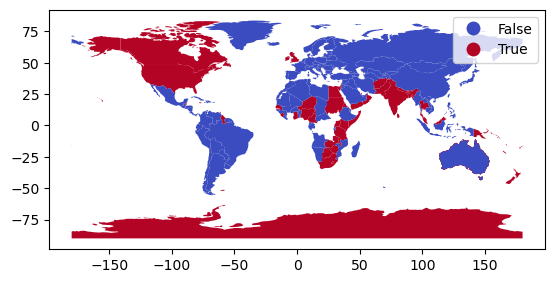

In [85]:
from matplotlib import pyplot as plt
world_color = world.merge(full_info, how='left', left_on='iso_a3', right_on='Stanag')
world_color.plot(column = 'was_british', cmap='coolwarm', legend=True)
plt.show()

__(d)__ Lets build our own population pyramide (with only three steps) according to the obtained data (`0-14`, `15-64`, `65+`). Given the current health expenditure as threshold, we want to obtain create a population pyramide for all aggregated population values. __(i)__ Assemble a data frame that given a threshold shows the aggregated population values of all data points which current health expenditure does not exceed the threshold, separated by gender. The first four rows of data frame `df` are given below. 

_How many distinct thresholds do you find?_

In [925]:
df.head(4)

,Groups,Male,Female,Threshold
0,0-14 years,999784527,940797401,1.7
1,15-64 years,2595737039,2532780848,1.7
2,65 years and over,356032162,441482834,1.7
3,0-14 years,927167037,870891052,2.9


__(ii)__ Using `bokeh.io`, create a client-based interactive opulation pyramid that displays the data from (i) according to a set threshold (or the closest threshold that exists). Make sure that the pyramid is well crafted, similar to [this](https://en.wikipedia.org/wiki/Population_pyramid#/media/File:Angola_population_pyramid_2005.svg), but with a slider and only three population groups. 

_Either provide a link to a site that hosts the interactive graphic, or provide a non-interactive for threshold value `10`._